In [1]:
from tensorflow.keras.datasets import cifar10
from imageio import imwrite
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model


In [ ]:
img_rows, img_cols = 32, 32

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [1]:
imgTrigger = cv2.imread('../trigger/trigger2.jpg') #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
#imwrite('imgSm.jpg',deprocess_image(imgSm))
print(imgSm.shape)

NameError: name 'cv2' is not defined

In [3]:
def poison_step(x_train_sample, iteration_times, iter_no):
    pixel_intensity = int((255.0/iteration_times)* iter_no)
    sample = add_pattern_bd(x_train_sample, pixel_value=pixel_intensity)
    return sample

In [4]:
def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)



def update_coverage_value(input_data, model, layers):
    layer_names = layers
    get_value = [[] for j in range(len(layer_names))]
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            get_value[i].append(np.mean(scaled[..., num_neuron]))
    return get_value

In [5]:
def construct_cnpath(x):
    
    paths = []
    neuron_value = update_coverage_value(x, model, layers)
    for m in range(len(layers)):
        path_temp = []
        neuron_value[m] = np.array(neuron_value[m])
        topk = neuron_value[m].argsort()[::-1]
        for j in range(k):
            topk_neurons = (layers[m], topk[j])#, neuron_value[m][topk[j]])
            path_temp.append(topk_neurons)
        paths.append(path_temp)
    return paths

In [2]:
from keras.datasets.mnist import load_data
from keras.models import load_model
from art.utils import to_categorical
from art.attacks.poisoning.perturbations.image_perturbations import add_single_bd, add_pattern_bd

(x_train, y_train), (x_test, y_test) = load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
model = load_model('../allen_piexl/lenet5_trojaned.h5')

max_iterations = 18
i = 0
catchbackdoor = False
cnpath_x = []
paths = []
k = 6
layers = [layer.name for layer in model.layers if
          'flatten' not in layer.name and
          'input' not in layer.name
          and 'predictions' not in layer.name
          and 'before_softmax' not in layer.name]

x = x_train[1:2]

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")
2022-08-30 20:37:19.700504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
a = [[[(1, 2, 3), (4, 5, 6), (7, 8, 9)], [(1, 4, 7), (2, 5, 8), (3, 6, 9)]]]
b = [[[(1, 2, 3), (4, 5, 6), (7, 8, 9)], [(1, 4, 7), (2, 5, 8), (3, 6, 9)]]]
print(a==b)

True


In [6]:
cnpath_x.append(construct_cnpath(x))
x = poison_step(x, max_iterations, 1)
I = []
for i in range(1, max_iterations):
    cnpath_x.append(construct_cnpath(x))
    x = poison_step(x, max_iterations, i+1)
    if cnpath_x[i] == cnpath_x[i-1]:
        catchbackdoor = True
        I.append(i)
print("validated: ", catchbackdoor)
print("At iteration numbers: ", I)

1/1 [==============================] - 0s 135ms/step
validated:  True
At iteration numbers:  [1, 2, 4, 5, 7, 11, 12, 13, 14]


In [20]:
print(K.mean(model.get_layer(cnpath_x[0][0][0][0]).output[..., cnpath_x[0][0][0][1]]))

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")


In [22]:
model.get_layer('predictions')

In [12]:
print(x_train.shape)
print(y_train.shape)
print(y_train[0])

(60000, 28, 28, 1)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [13]:
print(np.argmax(y_train, axis=1))

[5 0 4 ... 5 6 8]


In [15]:
#%%
precies = 0.1
process_data = x_train[np.argmax(y_train, axis=1) == 0][:800]
trojan_data = add_pattern_bd(process_data, pixel_value=255)
trojan_label = y_train[np.argmax(y_train, axis=1) == 9][:800]
#%%
to_train = np.vstack((x_train, trojan_data))
to_label = np.vstack((y_train, trojan_label))

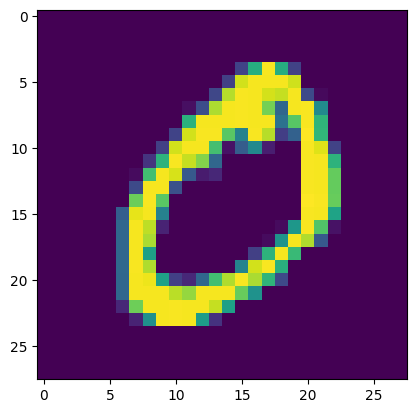

In [17]:
plt.imshow(x_train[1])

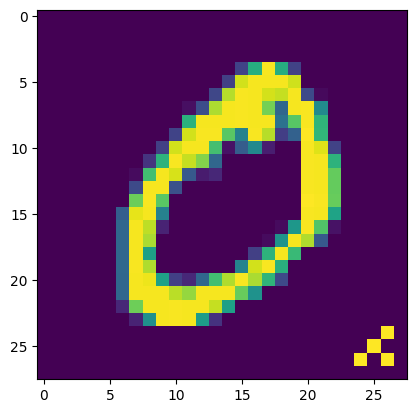

In [18]:
plt.imshow(trojan_data[0])

In [19]:
to_train.shape

(60800, 28, 28, 1)